In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from locscale.include.emmer.ndimage.map_utils import load_map
from locscale.include.emmer.ndimage.fsc_util import calculate_fsc_maps
from locscale.include.emmer.ndimage.filter import get_cosine_mask

target_locscale_map_path = "/home/abharadwaj1/dev/map_sharpening/emmernet/locscale_inputs/hybrid_version_C/locscale_hybrid_version_C_model_maps/emd_0282_hybrid_model_map_refined.mrc"
emmernet_epoch_evolution_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/epoch_evolution_emmernet/emd_0282_montecarlo"
mask_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/confidence_masks/emd_0282_FDR_confidence_final.map"
mask, apix = load_map(mask_path)

mask_binarised = (mask >= 0.99).astype(np.int_)
mask_smooth = get_cosine_mask(mask_binarised, 5)

target_map, _ = load_map(target_locscale_map_path)
masked_target_map = target_map * mask_smooth
epochs = [x.split("_")[1] for x in os.listdir(emmernet_epoch_evolution_path) if "epoch" in x]

epoch_map_paths = [os.path.join(emmernet_epoch_evolution_path, f"epoch_{epoch}".format(epoch), f"output_map_epoch_{epoch}_mean.mrc") for epoch in epochs]


In [3]:
assert all([os.path.exists(epoch_map_path) for epoch_map_path in epoch_map_paths])
assert os.path.exists(target_locscale_map_path)


In [4]:

fsc_curve_epochs = {}
for epoch, epoch_map_path in zip(epochs, epoch_map_paths):
    epoch_map = load_map(epoch_map_path)[0]
    masked_epoch_map = epoch_map * mask_smooth
    fsc_curve_epochs[epoch] = calculate_fsc_maps(masked_target_map, masked_epoch_map)

In [5]:
def pretty_lineplot_multiple_fsc_curves(freq, list_of_fscs, two_xaxis=True, figsize_cm=(14,8),\
                                        fontscale=2.5,font="Helvetica",linewidth=2,legends=None):
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    import seaborn as sns    
    from matplotlib.pyplot import cm
    import matplotlib as mpl
    ## Function not generic
    mpl.rcParams['pdf.fonttype'] = 42
    fig = plt.figure()

    figsize = (figsize_cm[0]/2.54, figsize_cm[1]/2.54)
    sns.set(rc={'figure.figsize':figsize})
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    sns.set_style("white")
    colors_rainbow = cm.rainbow(np.linspace(0,1,len(list_of_fscs)))

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.grid(False)
    
    for i,fsc_curve in enumerate(list_of_fscs):
        ax1.plot(freq,fsc_curve, linewidth=linewidth, color=colors_rainbow[i], label=legends[i])
        ax1.set_xlabel(r" Spatial Frequency, $d^{-1}(\AA^{-1}$)")
        ax1.set_ylabel("FSC")
    
    ax2 = ax1.twiny()
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xbound(ax1.get_xbound())        
    ax2.set_xticklabels([round(1/x,1) for x in ax1.get_xticks()])            
    ax2.set_xlabel(r'Resolution, $d (\AA)$')

    ax1.legend(legends)

    plt.tight_layout()
    return fig
    

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


<Figure size 432x288 with 0 Axes>

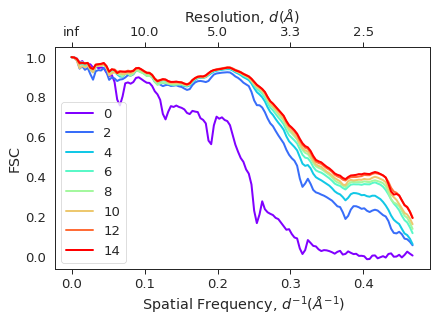

In [7]:
from locscale.include.emmer.ndimage.profile_tools import frequency_array
freq = frequency_array(fsc_curve_epochs[epochs[0]], apix=1.07)

list_of_fscs = [fsc_curve_epochs[epoch] for epoch in epochs]
legends = [f"{epoch}" for epoch in epochs]
fig = pretty_lineplot_multiple_fsc_curves(freq, list_of_fscs, figsize_cm=(16,12),\
                                        fontscale=1.5,font="Helvetica",linewidth=2,legends=legends)

In [9]:
output_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/network_performance" 
fig.savefig(os.path.join(output_dir, "fsc_curves_with_emmernet_prediction_target_modelmap.eps"), dpi=600, bbox_inches='tight')
# dump FSC curves
import pickle
fsc_curves_pickle_dict = {
    "fsc_curves": fsc_curve_epochs,
    "freq": freq,
    "apix": 1.07,
    "information" : "FSC curves for the target map and the emmernet prediction map for each epoch. EMDB ID: 0282. Mask used: FDR confidence mask (0.99 and smoothened using cosine filter of width 5). Target map: hybrid model map.\
                    Predicted maps generated by running Feature Enhance module of locscale on the unsharpened map (default parameters)."
}

with open(os.path.join(output_dir, "INFO_fsc_curves_with_emmernet_prediction_target_modelmap.pickle"), "wb") as f:
    pickle.dump(fsc_curves_pickle_dict, f)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Understanding why we see the FSC curve rise at the end? 

In [ ]:
from locscale.include.emmer.ndimage.filter import get_cosine_mask
test_emdb_pdb_id = "0282_6huo"
emdb, pdb = test_emdb_pdb_id.split("_")
test_emmernet_output_path = f"/home/abharadwaj1/papers/elife_paper/figure_information/outputs/emmernet_performance_test_set/emmernet_test_set/{test_emdb_pdb_id}/emd_{emdb}_emmernet_output.mrc"
test_locscale_map_path = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/hybrid_locscale_maps/emd_{emdb}_hybrid_locscale_C.mrc"
test_confidence_map_path = f"/home/abharadwaj1/papers/elife_paper/figure_information/data/confidence_masks/emd_{emdb}_FDR_confidence_final.map"

emmernet_map, apix = load_map(test_emmernet_output_path)
locscale_map, _ = load_map(test_locscale_map_path)
mask, _ = load_map(test_confidence_map_path)

# smoothen the mask 
from locscale.include.emmer.ndimage.filter import get_cosine_mask

mask_binarised = (mask >= 0.99).astype(np.int_)
mask_smooth = get_cosine_mask(mask_binarised, 5)
masked_emmernet_map = emmernet_map * mask_smooth
masked_target_map = locscale_map * mask_smooth

test_fsc_curve = calculate_fsc_maps(masked_target_map, masked_emmernet_map)
freq_test = frequency_array(test_fsc_curve, apix=apix)


    

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


<Figure size 453.543x283.465 with 0 Axes>

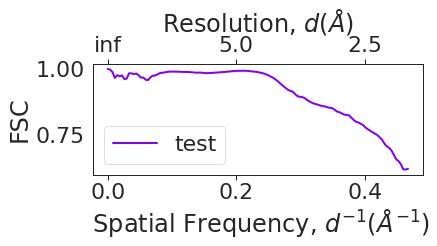

In [ ]:
fig = pretty_lineplot_multiple_fsc_curves(freq_test, [test_fsc_curve], legends=["test"], figsize_cm=(16,10))

In [ ]:
emmernet_map.shape

(256, 256, 256)

In [ ]:
apix

1.0700000127156575